# Coal Production Forecasting Model

This notebook implements time series forecasting to predict next day's coal production using historical data from ClickHouse.

## Overview
- **Target Variable**: `total_production_daily` (tons of coal mined per day)
- **Features**: Weather data equipment utilization quality grades fuel efficiency
- **Models**: SARIMA Prophet XGBoost LSTM
- **Evaluation**: MAE RMSE MAPE

In [13]:
# Import required libraries
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")

All libraries imported successfully!


## 1. Data Loading and Exploration

In [38]:
import os
import pandas as pd
import clickhouse_connect
import warnings
warnings.filterwarnings('ignore')

class ClickHouseConnector:
    def __init__(self):
        # For local Jupyter connecting to Docker ClickHouse
        self.host = 'localhost'  # Docker ClickHouse exposed to localhost
        self.port = 8123         # HTTP port
        self.user = 'admin'
        self.password = 'admin'
        self.database = 'dwh'    # Updated database name
        
        # Initialize connections
        self.client = None
        self.engine = None
        self._connect()
    
    def _connect(self):
        """Establish connections to ClickHouse"""
        try:
            # ClickHouse Connect client
            self.client = clickhouse_connect.get_client(
                host=self.host,
                port=self.port,
                username=self.user,
                password=self.password,
                database=self.database
            )
            
            # Remove SQLAlchemy engine - not needed for basic operations
            self.engine = None
            
            print(f"✅ Connected to ClickHouse at {self.host}:{self.port}")
            
        except Exception as e:
            print(f"❌ Failed to connect to ClickHouse: {e}")
            print("💡 Make sure ClickHouse Docker container is running: docker-compose up clickhouse")
            raise
    
    def query_to_dataframe(self, query):
        """Execute query and return pandas DataFrame"""
        try:
            result = self.client.query(query)
            # Try different ways to get the DataFrame
            if hasattr(result, 'df'):
                df = result.df
            elif hasattr(result, 'result_rows'):
                df = pd.DataFrame(result.result_rows, columns=result.column_names)
            elif hasattr(result, 'named_results'):
                df = pd.DataFrame(result.named_results)
            else:
                # Convert to list and create DataFrame
                df = pd.DataFrame(result.result_rows, columns=result.column_names)
            return df
        except Exception as e:
            print(f"❌ Query failed: {e}")
            raise
        
    def execute_query(self, query):
        """Execute query without returning results"""
        try:
            self.client.command(query)
            print("✅ Query executed successfully")
        except Exception as e:
            print(f"❌ Query failed: {e}")
            raise
    
    def get_daily_production_metrics(self, limit=None):
        """Get daily production metrics for forecasting"""
        query = """
        SELECT 
            date_id,
            mine_id,
            location_id,
            total_production_daily,
            average_quality_grade,
            equipment_utilization,
            fuel_efficiency,
            temperature_2m_mean,
            rainfall_mm
        FROM fact_daily_production
        ORDER BY date_id
        """
        
        if limit:
            query += f" LIMIT {limit}"
        
        return self.query_to_dataframe(query)
    
    def get_production_logs(self, limit=None):
        """Get raw production logs"""
        query = """
        SELECT 
            date,
            mine_id,
            shift,
            tons_extracted,
            quality_grade
        FROM production_logs
        ORDER BY date
        """
        
        if limit:
            query += f" LIMIT {limit}"
        
        return self.query_to_dataframe(query)
    
    def get_equipment_sensors(self, limit=None):
        """Get equipment sensor data"""
        query = """
        SELECT 
            timestamp,
            equipment_id,
            status,
            fuel_consumption,
            maintenance_alert
        FROM equipment_sensors
        ORDER BY timestamp
        """
        
        if limit:
            query += f" LIMIT {limit}"
        
        return self.query_to_dataframe(query)
    
    def close(self):
        """Close connections"""
        if self.client:
            self.client.close()
        if self.engine:
            self.engine.dispose()

# Global connector instance
connector = ClickHouseConnector()

✅ Connected to ClickHouse at localhost:8123


In [39]:
# Load daily production metrics
print("📊 Loading daily production metrics...")
df = connector.get_daily_production_metrics()

print(f"✅ Loaded {len(df)} records")
print(f"📅 Date range: {df['date_id'].min()} to {df['date_id'].max()}")
print(f"📈 Total production range: {df['total_production_daily'].min():.2f} to {df['total_production_daily'].max():.2f} tons")

df.head()

📊 Loading daily production metrics...
✅ Loaded 1095 records
📅 Date range: 2024-07-01 to 2025-06-30
📈 Total production range: 0.00 to 978.78 tons


,date_id,mine_id,location_id,total_production_daily,average_quality_grade,equipment_utilization,fuel_efficiency,temperature_2m_mean,rainfall_mm
0,2024-07-01,1,1,40.15,3.95,35.833332,0.167907,26.000000,1.7
1,2024-07-01,2,1,485.72,4.65,35.833332,2.031281,26.000000,1.7
2,2024-07-01,3,1,761.67,5.35,35.833332,3.185304,26.000000,1.7
3,2024-07-02,1,1,793.23,3.55,37.500000,3.701148,25.299999,29.9
4,2024-07-02,2,1,551.04,4.50,37.500000,2.571109,25.299999,29.9


In [40]:
# Data quality check
print("🔍 Data Quality Check:")
print(f"Missing values:")
print(df.isnull().sum())

print(f"Data types:")
print(df.dtypes)

print(f"Basic statistics:")
print(df.describe())

🔍 Data Quality Check:
Missing values:
date_id                   0
mine_id                   0
location_id               0
total_production_daily    0
average_quality_grade     0
equipment_utilization     0
fuel_efficiency           0
temperature_2m_mean       0
rainfall_mm               0
dtype: int64
Data types:
date_id                    object
mine_id                    object
location_id                 int64
total_production_daily    float64
average_quality_grade     float64
equipment_utilization     float64
fuel_efficiency           float64
temperature_2m_mean       float64
rainfall_mm               float64
dtype: object
Basic statistics:
       location_id  total_production_daily  average_quality_grade  \
count       1095.0             1095.000000            1095.000000   
mean           1.0              551.253982               4.519726   
std            0.0              215.023230               0.600856   
min            1.0                0.000000               3.050000   
25

## 2. Time Series Analysis

In [42]:
# Plot production trends
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=('Daily Production', 'Equipment Utilization', 'Fuel Efficiency', 'Temperature'),
    specs=[[{"secondary_y": False}, {"secondary_y": False}],
           [{"secondary_y": False}, {"secondary_y": False}]]
)

fig.add_trace(go.Scatter(x=df['date_id'], y=df['total_production_daily'], 
                         name='Production', line=dict(color='blue')), row=1, col=1)
fig.add_trace(go.Scatter(x=df['date_id'], y=df['equipment_utilization'], 
                         name='Utilization', line=dict(color='green')), row=1, col=2)
fig.add_trace(go.Scatter(x=df['date_id'], y=df['fuel_efficiency'], 
                         name='Fuel Efficiency', line=dict(color='red')), row=2, col=1)
fig.add_trace(go.Scatter(x=df['date_id'], y=df['temperature_2m_mean'], 
                         name='Temperature', line=dict(color='orange')), row=2, col=2)

fig.update_layout(height=600, title_text="Production Metrics Over Time")
fig.show()

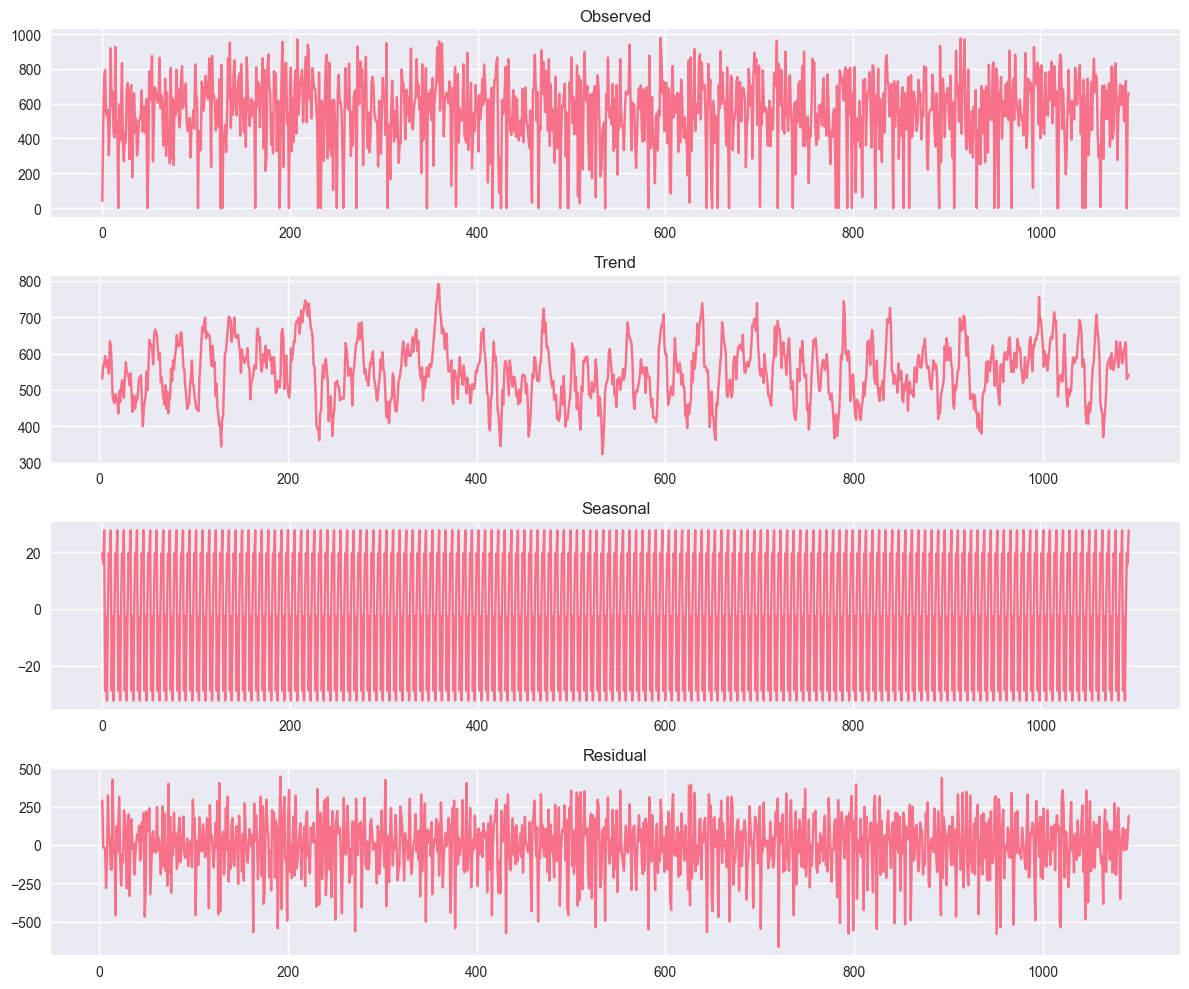

In [44]:
# Seasonal decomposition
production_series = df['total_production_daily']

try:
    decomposition = seasonal_decompose(production_series, period=7)  # Weekly seasonality
    
    fig, axes = plt.subplots(4, 1, figsize=(12, 10))
    decomposition.observed.plot(ax=axes[0], title='Observed')
    decomposition.trend.plot(ax=axes[1], title='Trend')
    decomposition.seasonal.plot(ax=axes[2], title='Seasonal')
    decomposition.resid.plot(ax=axes[3], title='Residual')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"⚠️ Seasonal decomposition failed: {e}")

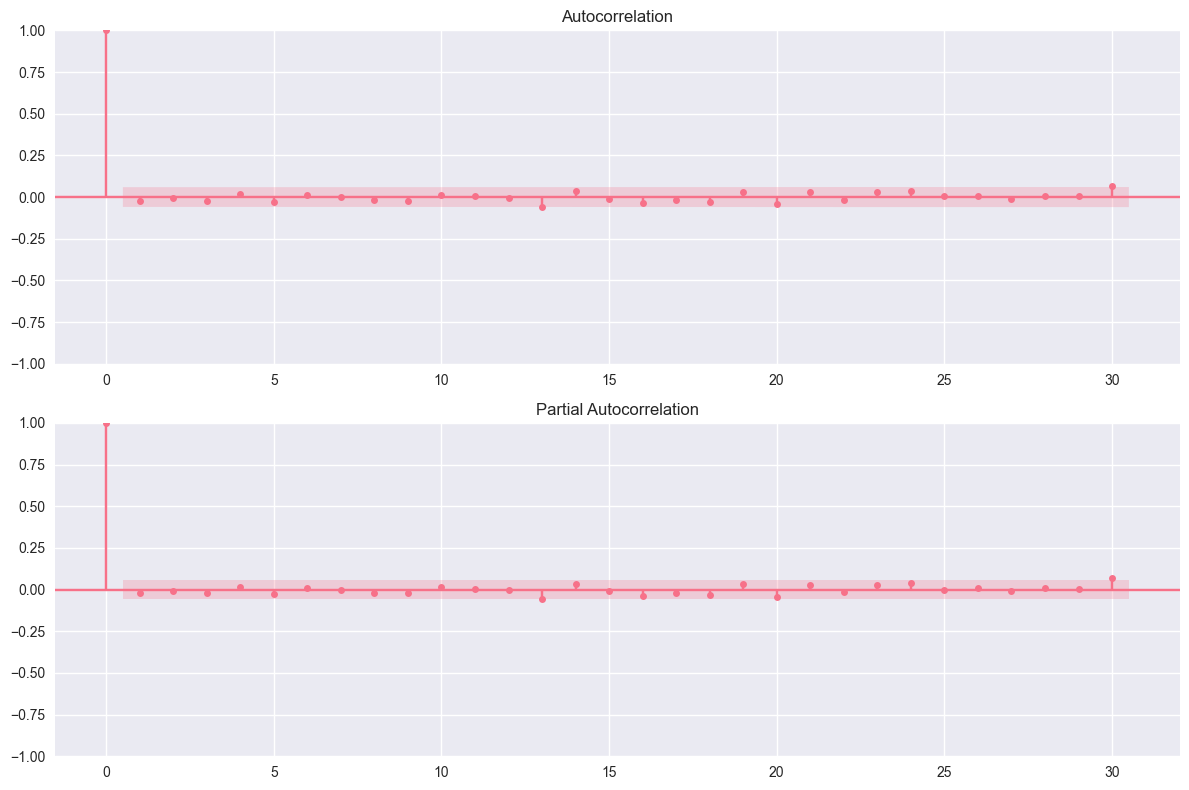

In [49]:
# ACF and PACF plots
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(production_series.dropna(), ax=axes[0], lags=30)
plot_pacf(production_series.dropna(), ax=axes[1], lags=30)
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [50]:
# Create time-based features
df_features = df.copy()

# Convert date_id to datetime if it's not already
if 'date_id' in df_features.columns:
    df_features['date_id'] = pd.to_datetime(df_features['date_id'])
    df_features = df_features.set_index('date_id')

# Time features
df_features['day_of_week'] = df_features.index.dayofweek
df_features['month'] = df_features.index.month
df_features['quarter'] = df_features.index.quarter
df_features['year'] = df_features.index.year

# Lag features
for lag in [1, 2, 3, 7, 14]:
    df_features[f'production_lag_{lag}'] = df_features['total_production_daily'].shift(lag)

# Rolling averages
for window in [3, 7, 14, 30]:
    df_features[f'production_ma_{window}'] = df_features['total_production_daily'].rolling(window=window).mean()
    df_features[f'production_std_{window}'] = df_features['total_production_daily'].rolling(window=window).std()

# Weather interaction features (using available columns)
if 'rainfall_mm' in df_features.columns and 'temperature_2m_mean' in df_features.columns:
    df_features['rainfall_temp_interaction'] = df_features['rainfall_mm'] * df_features['temperature_2m_mean']

# Equipment efficiency features
if 'equipment_utilization' in df_features.columns and 'fuel_efficiency' in df_features.columns:
    df_features['equipment_efficiency'] = df_features['equipment_utilization'] * df_features['fuel_efficiency']

print("✅ Feature engineering completed!")
print(f"📊 Total features: {len(df_features.columns)}")

✅ Feature engineering completed!
📊 Total features: 27


## 4. Model Training and Evaluation

In [51]:
# Prepare data for modeling
df_model = df_features.dropna()

# Split data chronologically (80% train, 20% test)
split_idx = int(len(df_model) * 0.8)
train_data = df_model.iloc[:split_idx]
test_data = df_model.iloc[split_idx:]

print(f"📊 Training data: {len(train_data)} records")
print(f"📊 Test data: {len(test_data)} records")
print(f"📅 Train period: {train_data.index.min()} to {train_data.index.max()}")
print(f"�� Test period: {test_data.index.min()} to {test_data.index.max()}")

📊 Training data: 852 records
📊 Test data: 214 records
📅 Train period: 2024-07-10 00:00:00 to 2025-04-20 00:00:00
�� Test period: 2025-04-20 00:00:00 to 2025-06-30 00:00:00


In [56]:
# XGBoost Model
print("🚀 Training XGBoost model...")

# Select features (exclude target, date, and non-numeric columns)
exclude_cols = ['total_production_daily', 'mine_id', 'location_id']
feature_cols = [col for col in df_model.columns if col not in exclude_cols and df_model[col].dtype in ['int64', 'float64']]

print(f"Selected features: {feature_cols}")
print(f"Number of features: {len(feature_cols)}")

X_train = train_data[feature_cols]
y_train = train_data['total_production_daily']
X_test = test_data[feature_cols]
y_test = test_data['total_production_daily']

# Check data types
print(f"X_train dtypes: {X_train.dtypes.value_counts()}")

# Train XGBoost
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    random_state=42
)

xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)

# Calculate metrics
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred))

# Fix MAPE calculation to handle zero values
def calculate_mape(y_true, y_pred):
    """Calculate MAPE avoiding division by zero"""
    # Filter out zero values to avoid division by zero
    mask = y_true != 0
    if mask.sum() == 0:
        return float('inf')
    
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    
    mape = np.mean(np.abs((y_true_filtered - y_pred_filtered) / y_true_filtered)) * 100
    return mape

xgb_mape = calculate_mape(y_test, xgb_pred)

print(f"✅ XGBoost Results:")
print(f"   MAE: {xgb_mae:.2f} tons")
print(f"   RMSE: {xgb_rmse:.2f} tons")
print(f"   MAPE: {xgb_mape:.2f}%")

# Additional insights
print(f"\n📊 Data Insights:")
print(f"   Test data range: {y_test.min():.2f} to {y_test.max():.2f} tons")
print(f"   Predictions range: {xgb_pred.min():.2f} to {xgb_pred.max():.2f} tons")
print(f"   Zero values in test data: {(y_test == 0).sum()}")

🚀 Training XGBoost model...
Selected features: ['average_quality_grade', 'equipment_utilization', 'fuel_efficiency', 'temperature_2m_mean', 'rainfall_mm', 'production_lag_1', 'production_lag_2', 'production_lag_3', 'production_lag_7', 'production_lag_14', 'production_ma_3', 'production_std_3', 'production_ma_7', 'production_std_7', 'production_ma_14', 'production_std_14', 'production_ma_30', 'production_std_30', 'rainfall_temp_interaction', 'equipment_efficiency']
Number of features: 20
X_train dtypes: float64    20
Name: count, dtype: int64
✅ XGBoost Results:
   MAE: 34.24 tons
   RMSE: 46.35 tons
   MAPE: 6.46%

📊 Data Insights:
   Test data range: 0.00 to 975.94 tons
   Predictions range: -0.62 to 915.27 tons
   Zero values in test data: 11


In [ ]:
# Prophet Model
print("🚀 Training Prophet model...")

# Prepare data for Prophet
prophet_df = df_model.reset_index()
prophet_df = prophet_df[['date_id', 'total_production_daily']].rename(
    columns={'date_id': 'ds', 'total_production_daily': 'y'}
)

# Split for Prophet
prophet_train = prophet_df.iloc[:split_idx]
prophet_test = prophet_df.iloc[split_idx:]

# Train Prophet
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    seasonality_mode='multiplicative'
)

prophet_model.fit(prophet_train)

# Make predictions
prophet_future = prophet_model.make_future_dataframe(periods=len(prophet_test))
prophet_forecast = prophet_model.predict(prophet_future)
prophet_pred = prophet_forecast.iloc[split_idx:]['yhat'].values

# Calculate metrics
prophet_mae = mean_absolute_error(y_test, prophet_pred)
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_pred))
prophet_mape = calculate_mape(y_test, prophet_pred)  # Use the fixed MAPE function

print(f"✅ Prophet Results:")
print(f"   MAE: {prophet_mae:.2f} tons")
print(f"   RMSE: {prophet_rmse:.2f} tons")
print(f"   MAPE: {prophet_mape:.2f}%")

In [ ]:
# SARIMA Model
print(\🚀 Training SARIMA model...\)

try:
    # Use production series for SARIMA
    sarima_train = production_series.iloc[:split_idx]
    
    # Fit SARIMA model (111)(1117) - adjust parameters based on ACF/PACF
    sarima_model = SARIMAX(sarima_train order=(1 1 1) seasonal_order=(1 1 1 7))
    sarima_fitted = sarima_model.fit(disp=False)
    
    # Make predictions
    sarima_pred = sarima_fitted.forecast(steps=len(test_data))
    
    # Calculate metrics
    sarima_mae = mean_absolute_error(y_test sarima_pred)
    sarima_rmse = np.sqrt(mean_squared_error(y_test sarima_pred))
    sarima_mape = np.mean(np.abs((y_test - sarima_pred) / y_test)) * 100
    
    print(f\✅ SARIMA Results:\)
    print(f\   MAE: {sarima_mae:.2f} tons\)
    print(f\   RMSE: {sarima_rmse:.2f} tons\)
    print(f\   MAPE: {sarima_mape:.2f}%\)
    
except Exception as e:
    print(f\⚠️ SARIMA model failed: {e}\)
    sarima_mae = sarima_rmse = sarima_mape = float('inf')

## 5. Model Comparison and Visualization

In [ ]:
# Compare models
models_comparison = pd.DataFrame({
    'Model': ['XGBoost' 'Prophet' 'SARIMA']
    'MAE': [xgb_mae prophet_mae sarima_mae]
    'RMSE': [xgb_rmse prophet_rmse sarima_rmse]
    'MAPE': [xgb_mape prophet_mape sarima_mape]
})

print(\📊 Model Comparison:\)
print(models_comparison.round(2))

# Find best model
best_model_idx = models_comparison['MAE'].idxmin()
best_model = models_comparison.loc[best_model_idx 'Model']
print(f\\🏆 Best Model: {best_model} (lowest MAE)\)

In [ ]:
# Plot predictions vs actual
fig = make_subplots(
    rows=3 cols=1
    subplot_titles=('XGBoost Predictions' 'Prophet Predictions' 'SARIMA Predictions')
    vertical_spacing=0.1
)

# Actual values
fig.add_trace(go.Scatter(x=test_data.index y=y_test 
                         name='Actual' line=dict(color='black' width=2)) 
              row=1 col=1)
fig.add_trace(go.Scatter(x=test_data.index y=y_test 
                         name='Actual' line=dict(color='black' width=2)) 
              row=2 col=1)
fig.add_trace(go.Scatter(x=test_data.index y=y_test 
                         name='Actual' line=dict(color='black' width=2)) 
              row=3 col=1)

# Predictions
fig.add_trace(go.Scatter(x=test_data.index y=xgb_pred 
                         name='XGBoost Pred' line=dict(color='blue')) 
              row=1 col=1)
fig.add_trace(go.Scatter(x=test_data.index y=prophet_pred 
                         name='Prophet Pred' line=dict(color='green')) 
              row=2 col=1)
fig.add_trace(go.Scatter(x=test_data.index y=sarima_pred 
                         name='SARIMA Pred' line=dict(color='red')) 
              row=3 col=1)

fig.update_layout(height=900 title_text=\Model Predictions vs Actual Values\)
fig.show()

## 6. Feature Importance (XGBoost)

In [ ]:
# Feature importance
feature_importance = pd.DataFrame({
    'feature': feature_cols
    'importance': xgb_model.feature_importances_
}).sort_values('importance' ascending=False)

fig = px.bar(feature_importance.head(15) x='importance' y='feature' 
             title='Top 15 Feature Importance (XGBoost)' orientation='h')
fig.show()

print(\🔍 Top 10 Most Important Features:\)
print(feature_importance.head(10))

## 7. Next Day Prediction

In [ ]:
# Prepare data for next day prediction
latest_data = df_features.iloc[-1:]
next_day_features = latest_data[feature_cols]

# Make prediction using best model
if best_model == 'XGBoost':
    next_day_pred = xgb_model.predict(next_day_features)[0]
elif best_model == 'Prophet':
    # Create future date for Prophet
    last_date = df_features.index[-1]
    next_date = last_date + pd.Timedelta(days=1)
    future_df = pd.DataFrame({'ds': [next_date]})
    next_day_pred = prophet_model.predict(future_df)['yhat'].iloc[0]
else:  # SARIMA
    next_day_pred = sarima_fitted.forecast(steps=1)[0]

print(f\🔮 Next Day Production Prediction ({best_model}):\)
print(f\   Date: {(df_features.index[-1] + pd.Timedelta(days=1)).strftime('%Y-%m-%d')}\)
print(f\   Predicted Production: {next_day_pred:.2f} tons\)
print(f\   Current Production: {df_features['total_production_daily'].iloc[-1]:.2f} tons\)
print(f\   Change: {((next_day_pred - df_features['total_production_daily'].iloc[-1]) / df_features['total_production_daily'].iloc[-1] * 100):.2f}%\)

## 8. Model Deployment Preparation

In [ ]:
# Save best model
import joblib
import pickle

# Save XGBoost model
joblib.dump(xgb_model '../models/xgboost_production_model.pkl')

# Save Prophet model
with open('../models/prophet_production_model.pkl' 'wb') as f:
    pickle.dump(prophet_model f)

# Save feature columns
with open('../models/feature_columns.pkl' 'wb') as f:
    pickle.dump(feature_cols f)

# Save scaler if used
scaler = StandardScaler()
scaler.fit(X_train)
joblib.dump(scaler '../models/scaler.pkl')

print(\✅ Models saved successfully!\)
print(\📁 Models saved in: ../models/\)

# Create prediction function
def predict_next_day_production():
    \\\Function to predict next day's production\\\
    # Load latest data
    latest_data = connector.get_daily_production_metrics(limit=30)
    # ... implement prediction logic
    return next_day_pred

print(\\🎯 Ready for deployment!\)